In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import glob
import data_utils.data_utils_celeba_pytorch as data_utils
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import numpy as np
import pandas as pd
import os

In [9]:
# Root directory for dataset
#dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

In [6]:
attributes = pd.read_csv('Data/list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('Data/list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

In [7]:
train = matched[matched['partition']==0]
valid = matched[matched['partition']==1]
test = matched[matched['partition']==2]
train[1:1000].to_csv('train.csv')
valid[1:1000].to_csv('valid.csv')
test[1:1000].to_csv('test.csv')

In [11]:
IMAGE_SHAPE = [73,60,3]
# Paths to data
TRAIN_PATH =  "Data/train.csv" 
VALID_PATH = "Data/valid.csv" 
TEST_PATH = "Data/test.csv" 
IMAGE_PATHS = "/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Deep Learning/Projects/Algorithmic fairness/Data/celeba/"
TARGET_COL = 'Smiling'
NUM_CLASSES = 2

# train holds both X (input) and t (target/truth)
data_train = data_utils.CelebADataset(TRAIN_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [12]:
dataloader = DataLoader(data_valid, batch_size=128,shuffle=True, num_workers=6)

In [13]:
def show_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch = \
            sample_batched['image'], sample_batched['target']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [14]:
from tqdm import tqdm_notebook
for i_batch, sample_batched in tqdm_notebook(enumerate(dataloader)):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['target'].size())

    # observe 4th batch and stop.
    if i_batch == 10:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

0 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
1 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
2 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
3 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
4 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
5 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
6 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
7 torch.Size([104, 3, 73, 60]) torch.Size([104, 2])



In [17]:
sample_batched['attributes'][0]

tensor([ 1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1.,
         1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
       dtype=torch.float64)

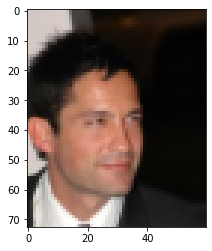

In [18]:
plt.imshow(np.transpose(vutils.make_grid(sample_batched['image'][5], padding=2,normalize=True).cpu(),(1,2,0)))

In [19]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [20]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [21]:
height, width, channels = IMAGE_SHAPE

conv_out_channels =  16 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
 


conv1_h = int(height - kernel_size + 2 * conv_pad / conv_stride + 1)
conv1_w = int(width - kernel_size + 2 * conv_pad / conv_stride + 1)

# Keep track of features to output layer
features_cat_size = int(conv_out_channels * conv1_h * conv1_w)\

# <-- Number of features concatenated before output layer
  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)

             
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        #x_img = x_img.permute(0,3,1,2)
        features_img = relu(self.conv_1(x_img))
        
        features_img = features_img.view(-1, features_cat_size)

        ## Output layer where all features are in use ##
        
        out['out'] = self.l_out(features_img)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (l_out): Linear(in_features=61824, out_features=2, bias=False)
)


In [22]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [23]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
image = randnorm(_img_shape)
image = image.transpose(0,3, 1, 2)
_x_image = get_variable(Variable(torch.from_numpy(image)))

# test the forward pass
output = net(x_img=_x_image)
output['out'].shape

torch.Size([128, 2])

In [27]:
# Setup settings for training 
batch_size=128
max_iter = 200
log_every = 5
eval_every = 5
num_epochs = 10

# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen_train = DataLoader(data_train, batch_size, shuffle=True, num_workers=6)
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)

# Train network
net.train()
for epoch in range(num_epochs):
    for i, batch_train in enumerate(batch_gen_train):
        if i % eval_every == 0:

            # Do the validaiton
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            for batch_valid in batch_gen_valid:
                num = len(batch_valid['target'])
                output = net(**get_input(batch_valid))
                labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                val_losses += criterion(output['out'], labels_argmax) * num
                val_accs += accuracy(output['out'], labels_argmax) * num
                val_lengths += num

            # Divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            valid_iter.append(i)
    #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
            net.train()

        # Train network
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        train_iter.append(i)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Log i figure
        if i % log_every == 0:
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            clear_output(wait=True)
            
            print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
            print("Valid, it: {} loss: {:.2f} accs: {:.4f}".format(i, valid_loss[-1], valid_accs[-1]))

        if max_iter < i:
            break

Train, it: 5 loss: 0.00 accs: 1.00
Valid, it: 5 loss: 0.00 accs: 1.0000


In [25]:
print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
print("Valid, it: {} loss: {:.2f} accs: {:.4f}".format(i, valid_loss[-1], valid_accs[-1]))

Train, it: 7 loss: 0.00 accs: 1.00
Valid, it: 7 loss: 0.00 accs: 1.0000


In [26]:
net.eval()
val_male_losses,val_male_accs,val_male_lengths,val_female_losses,val_female_accs,val_female_lengths = 0, 0, 0, 0, 0, 0
i=0
for batch_valid in batch_gen_valid:
    num = len(batch_valid)
    output = net(**get_input(batch_valid))
    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
    
    gender = batch_valid['attributes'][:,19]
    male = np.where(gender==1)
    female = np.where(gender==0)

    val_male_losses += criterion(output['out'][male], labels_argmax[male]) * len(male[0]) 
    val_male_accs += accuracy(output['out'][male], labels_argmax[male]) * len(male[0]) 
    val_male_lengths += len(male[0])
    val_female_losses += criterion(output['out'][female], labels_argmax[female]) * len(female[0]) 
    val_female_accs += accuracy(output['out'][female], labels_argmax[female]) * len(female[0]) 
    val_female_lengths += len(female[0])

# Divide by the total accumulated batch sizes
val_male_losses /= val_male_lengths
val_male_accs /= val_male_lengths

val_female_losses /= val_female_lengths
val_female_accs /= val_female_lengths

print("Valid Male, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_male_losses, val_male_accs))
print("Valid Female, it: {} loss: {:.2f} accs: {:.4f}\n".format(i, val_female_losses, val_female_accs))

RuntimeError: invalid argument 2: dimension -1 out of range of 2D tensor at ../aten/src/TH/generic/THTensor.cpp:41

In [ ]:
batch_valid['attributes']

In [ ]:
from tqdm import tqdm_notebook
d = dict()
d['im'] = np.zeros(tuple([1000]+IMAGE_SHAPE))
k=0
l= [data.train['images'][i].decode() for i in  range(0,1000)]
for j in tqdm_notebook(l):
    im = imread(j)
    im = resize(im,output_shape=IMAGE_SHAPE, mode='reflect', anti_aliasing=True)
    d['im'][k] = im
    k+=1

In [ ]:
valid = data.valid
valid_new = valid
valid_new['images'] = np.zeros(tuple([1000] + IMAGE_SHAPE), dtype='float32')
for i, im in enumerate(data.test['images']):
    im = imread(im.decode())
    valid_new['images'][i] = resize(im, output_shape=IMAGE_SHAPE, mode='reflect', anti_aliasing=True)

In [ ]:
d = dict()
d['im'] = np.zeros(tuple([1000]+IMAGE_SHAPE))
k=0
for j in tqdm_notebook([data.train['images'][i] for i in  range(0,1000)]):
    im = imread(j.decode())
    im = resize(im,output_shape=IMAGE_SHAPE, mode='reflect', anti_aliasing=True)
    d['im'][k] = im
    k+=1

In [ ]:
d['im'][0].shape

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(batch_valid['images'][6]), padding=2,normalize=True).cpu(),(0,1,2)))

In [ ]:
pred_label = [np.where(output['out'][i]==m[i]) for i in range(0,104)]

In [ ]:
pd.DataFrame([labels_argmax[i].numpy() == pred_label[i][0][0] for i in range(0,104)]).head(30)

In [ ]:
pred_label[1][0][0]

In [ ]:
pred_label[1] == labels_argmax[1]

In [ ]:
m = [max(output['out'][i]) for i in range(0,104)]

In [ ]:
criterion(output['out'][male], labels_argmax[male])

In [ ]:
output['out'][[1,2,4]]

In [ ]:
criterion(output['out'][1:2], labels_argmax[1:2])

In [ ]:
batch_valid['attributes'][20]

In [ ]:
labels_argmax

In [ ]:
height, width, channels = IMAGE_SHAPE

conv_out_channels =  16 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
 
def conv_dim(dim_size):
    int(dim_size - kernel_size + 2 * conv_pad / conv_stride + 1)

conv1_h = int(height - kernel_size + 2 * conv_pad / conv_stride + 1)
conv1_w = int(width - kernel_size + 2 * conv_pad / conv_stride + 1)

# Keep track of features to output layer
features_cat_size = int(conv_out_channels * conv1_h * conv1_w)\

# <-- Number of features concatenated before output layer
  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)

             
        self.l_out = Linear(in_features=features_cat_size,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        x_img = x_img.permute(0,3,1,2)
        features_img = relu(self.conv_1(x_img))
        
        features_img = features_img.view(-1, features_cat_size)

        ## Output layer where all features are in use ##
        
        out['out'] = self.l_out(features_img)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)